In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img, title="", cmap="gray", size=6):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

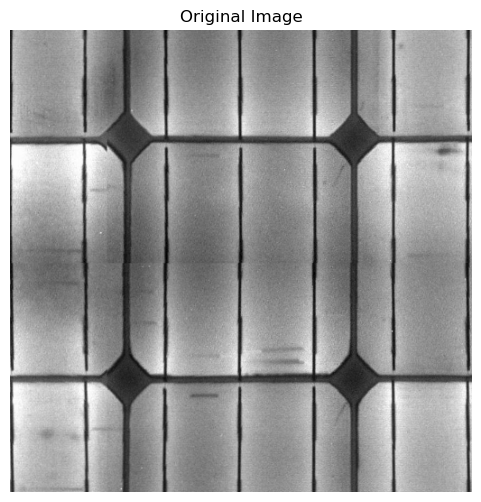

In [3]:
img = cv2.imread(r"D:\PROGRAMMING\Internships_assignments\ResearchInternIITMandi\dataset\dataset\ARTS_00007_r4_c5.png", cv2.IMREAD_GRAYSCALE)
show(img, "Original Image")

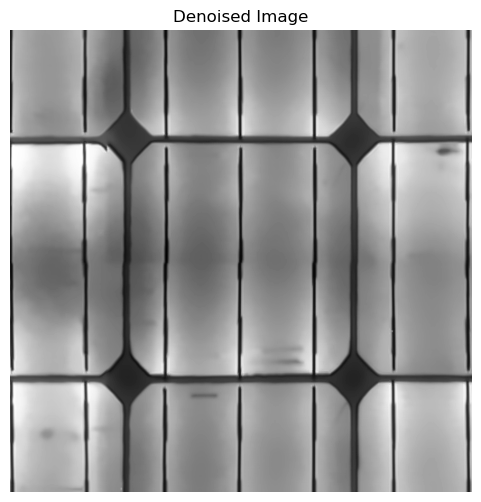

In [4]:
denoised = cv2.fastNlMeansDenoising(img, h=10)
show(denoised, "Denoised Image")

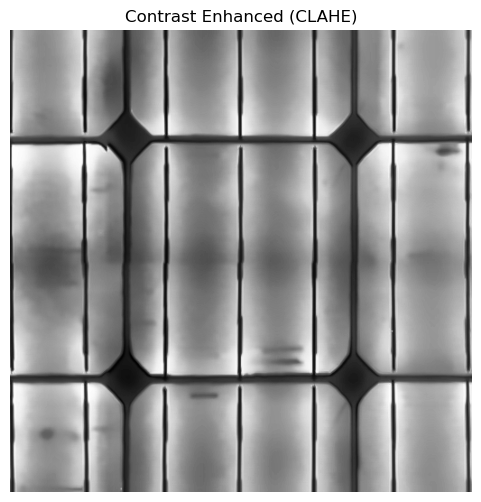

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(denoised)
show(enhanced, "Contrast Enhanced (CLAHE)")

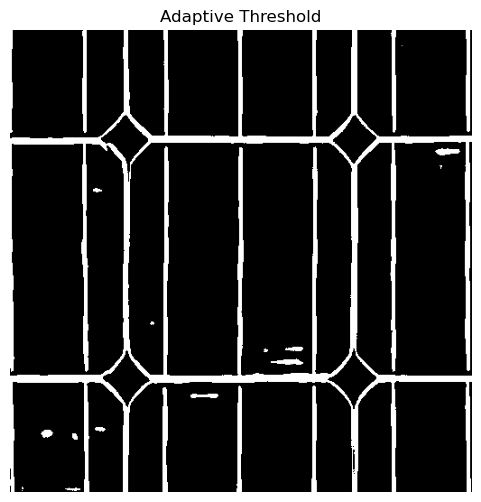

In [6]:
th = cv2.adaptiveThreshold(enhanced, 255,
                           cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV,
                           15, 15)
show(th, "Adaptive Threshold")

In [7]:
# NEW IMPLEMENTATION

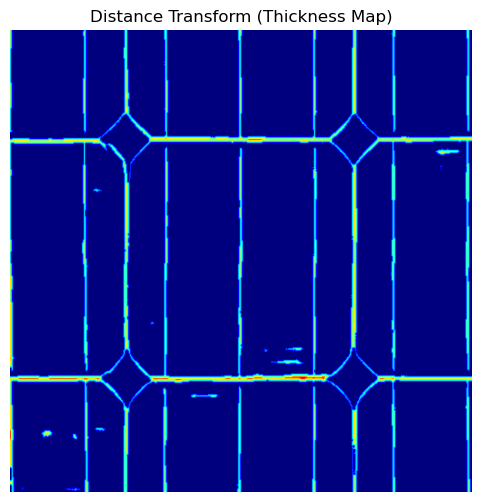

In [8]:
dist = cv2.distanceTransform(th, cv2.DIST_L2, 5)
show(dist, "Distance Transform (Thickness Map)", cmap="jet")


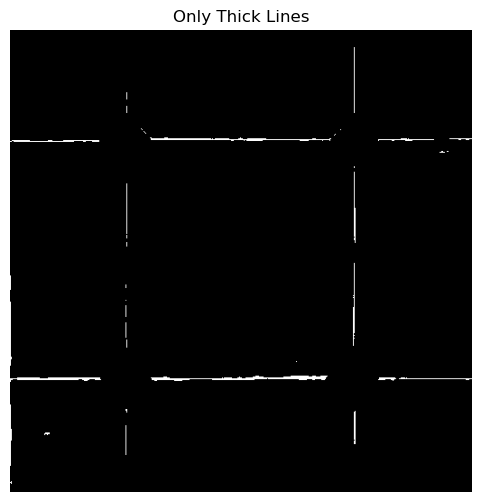

In [9]:
thick_only = np.zeros_like(th)
thick_only[dist > 3.0] = 255   # ← tune 3.5–5 depending on resolution
show(thick_only, "Only Thick Lines")


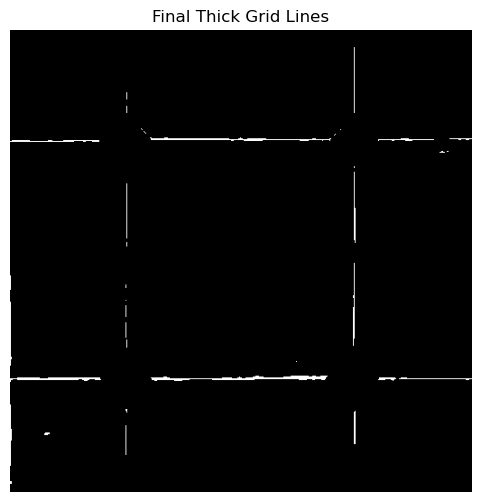

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thick_only = cv2.morphologyEx(thick_only, cv2.MORPH_CLOSE, kernel, iterations=1)
show(thick_only, "Final Thick Grid Lines")


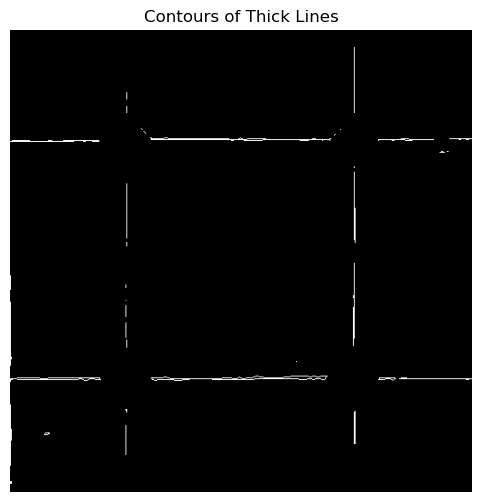

In [12]:
# Find contours from the thresholded image
contours, _ = cv2.findContours(thick_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours for visualization
contour_image = np.zeros_like(thick_only)
cv2.drawContours(contour_image, contours, -1, (255), 1)
show(contour_image, "Contours of Thick Lines")


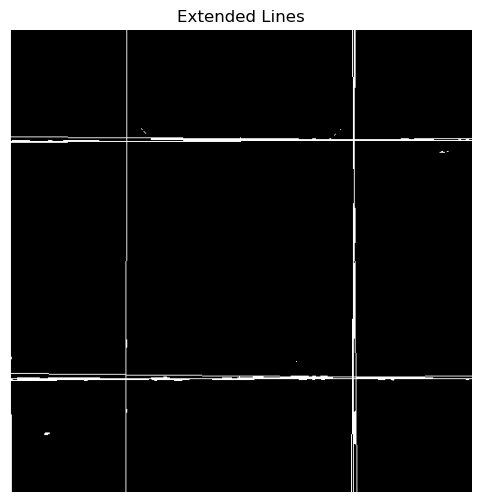

In [13]:
# Define a minimum length threshold for extension (in pixels)
length_threshold = 50  # You can adjust this based on your image

extended_lines = np.copy(thick_only)

# Iterate through the contours
for contour in contours:
    # Get the length of the contour (approximate the contour as a polyline)
    contour_length = cv2.arcLength(contour, False)  # False for open contours

    # If the length is greater than the threshold, we try to extend the line
    if contour_length > length_threshold:
        # Fit a line to the contour using cv2.fitLine (find the best line fit for the contour)
        [vx, vy, x, y] = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
        
        # Calculate points to extend the line
        # Line equation: (x, y) = (x0, y0) + t * (vx, vy)
        # Extend line in both directions
        point1 = (int(x - vx * 1000), int(y - vy * 1000))  # Extend in one direction
        point2 = (int(x + vx * 1000), int(y + vy * 1000))  # Extend in the opposite direction

        # Draw the extended line on the image
        cv2.line(extended_lines, point1, point2, (255), 1)  # 255 for white color, 1 for thickness

show(extended_lines, "Extended Lines")

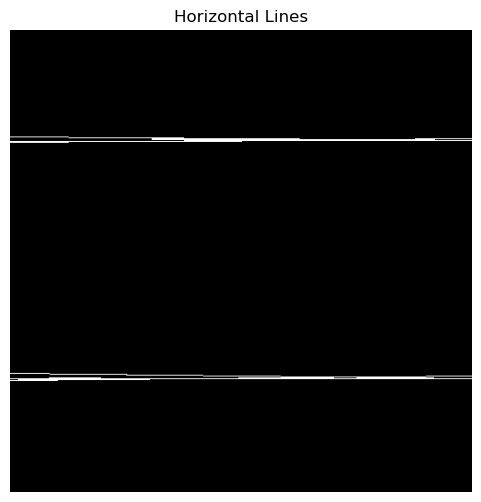

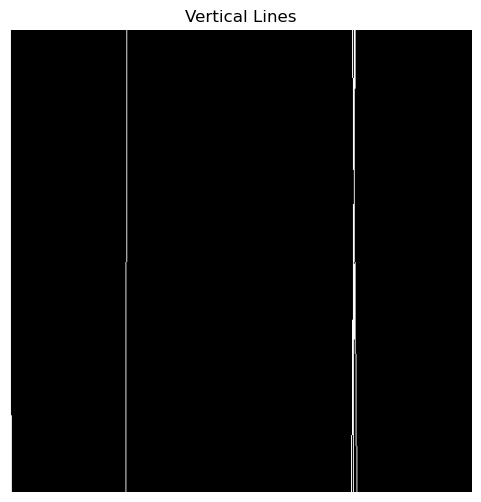

In [16]:
lines = extended_lines.copy()

# Detect horizontal lines
h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
horizontal = cv2.morphologyEx(lines, cv2.MORPH_OPEN, h_kernel)

# Detect vertical lines
v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
vertical = cv2.morphologyEx(lines, cv2.MORPH_OPEN, v_kernel)

show(horizontal, "Horizontal Lines")
show(vertical, "Vertical Lines")


Merged vertical lines: [128, 381]
Merged horizontal lines: [121, 384]


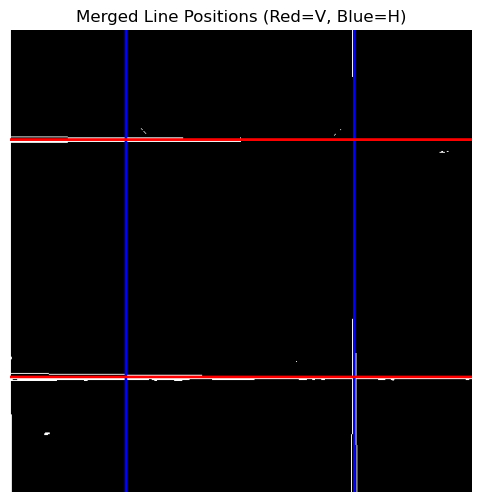

In [31]:
# ---------- RAW PROJECTIONS ----------
vx_raw = np.where(vertical.sum(axis=0) > 0)[0]
hy_raw = np.where(horizontal.sum(axis=1) > 0)[0]

# ---------- MERGE CLOSE LINES ----------
def merge_close_lines(coords, min_dist=25):
    if len(coords) == 0:
        return []

    merged = []
    current = [coords[0]]

    for c in coords[1:]:
        if abs(c - current[-1]) <= min_dist:
            current.append(c)
        else:
            merged.append(int(np.mean(current)))
            current = [c]

    merged.append(int(np.mean(current)))
    return merged

vx = merge_close_lines(vx_raw, min_dist=30)
hy = merge_close_lines(hy_raw, min_dist=30)

# ---------- IGNORE LINES COINCIDING WITH IMAGE BORDER ----------
h, w = lines.shape
border_margin = 10  # Lines within 10 px of image edge are ignored

vx = [x for x in vx if border_margin < x < w - border_margin]
hy = [y for y in hy if border_margin < y < h - border_margin]

print("Merged vertical lines:", vx)
print("Merged horizontal lines:", hy)

# ---------- VISUAL DEBUG ----------
debug = cv2.cvtColor(lines, cv2.COLOR_GRAY2BGR)

for x in vx:
    cv2.line(debug, (x, 0), (x, h), (0, 0, 255), 2)

for y in hy:
    cv2.line(debug, (0, y), (w, y), (255, 0, 0), 2)

show(debug, "Merged Line Positions (Red=V, Blue=H)")


Middle cell bounds: 128 121 381 384


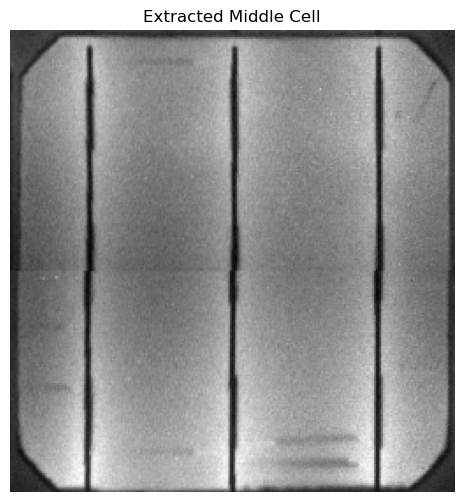

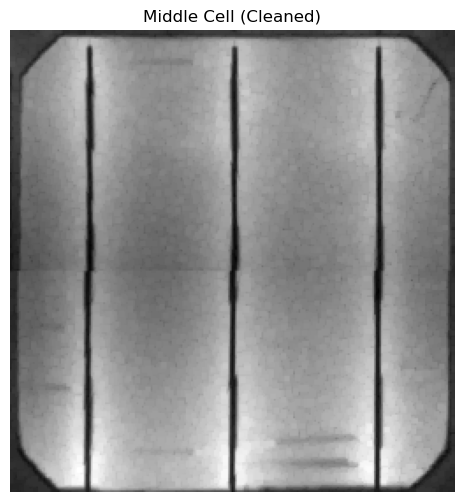

In [33]:
assert len(vx) == 2, f"Expected 2 vertical lines, got {len(vx)}"
assert len(hy) == 2, f"Expected 2 horizontal lines, got {len(hy)}"
x1, x2 = sorted(vx)
y1, y2 = sorted(hy)

print("Middle cell bounds:", x1, y1, x2, y2)
middle_cell = img[y1:y2, x1:x2]
show(middle_cell, "Extracted Middle Cell")
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
middle_cell_clean = cv2.morphologyEx(middle_cell, cv2.MORPH_OPEN, kernel)
show(middle_cell_clean, "Middle Cell (Cleaned)")